In [1]:
import uproot
import numpy as np
import glob

import torch
from torch.utils.data import Dataset, DataLoader

import itertools

import Models_torch
import HierarchyDatasets
import TrainingMetrics

In [2]:
###########################################################
# Define file
###########################################################

# Get training file
#trainFileNames = glob.glob('/Users/isobel/Desktop/DUNE/2024/Hierarchy/files/ccnutree_*.npz')
trainFileNames = glob.glob('/Users/isobel/Desktop/DUNE/2024/Hierarchy/files/ccnutree_*_track.npz')
print(trainFileNames)

['/Users/isobel/Desktop/DUNE/2024/Hierarchy/files/ccnutree_1_track.npz', '/Users/isobel/Desktop/DUNE/2024/Hierarchy/files/ccnutree_0_track.npz']


In [3]:
###########################################################
# Hyperparameters
###########################################################

N_EPOCHS = 5
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
DROPOUT_RATE = 0.5

In [4]:
###########################################################
# Get data from file
###########################################################

# Variables
variables_train = np.empty((0, 19))
variables_test = np.empty((0, 19))
# Training cut
trainingCutDCA_train = np.empty((0), dtype='float')
trainingCutDCA_test = np.empty((0), dtype='float')
# Truth
y_train = np.empty((0, 2), dtype='int')
y_test = np.empty((0, 2), dtype='int')
isTruePrimaryLink_train = np.empty((0), dtype='int')
isTruePrimaryLink_test = np.empty((0), dtype='int')
hasNeutronParent_train = np.empty((0), dtype='bool')
hasNeutronParent_test = np.empty((0), dtype='bool')

for trainFileName in trainFileNames :
    print('Reading file: ', str(trainFileName),', This may take a while...')
    
    data = np.load(trainFileName)

    # Variables
    variables_train = np.concatenate((variables_train, data['variables_train']), axis=0)
    variables_test = np.concatenate((variables_test, data['variables_test']), axis=0)
    # Training cut
    trainingCutDCA_train = np.concatenate((trainingCutDCA_train, data['trainingCutDCA_train']), axis=0)
    trainingCutDCA_test = np.concatenate((trainingCutDCA_test, data['trainingCutDCA_test']), axis=0)
    # Truth
    y_train = np.concatenate((y_train, data['y_train']), axis=0)
    y_test = np.concatenate((y_test, data['y_test']), axis=0)
    isTruePrimaryLink_train = np.concatenate((isTruePrimaryLink_train, data['isTruePrimaryLink_train']), axis=0)
    isTruePrimaryLink_test = np.concatenate((isTruePrimaryLink_test, data['isTruePrimaryLink_test']), axis=0)    
    hasNeutronParent_train = np.concatenate((hasNeutronParent_train, data['hasNeutronParent_train']), axis=0)
    hasNeutronParent_test = np.concatenate((hasNeutronParent_test, data['hasNeutronParent_test']), axis=0)

Reading file:  /Users/isobel/Desktop/DUNE/2024/Hierarchy/files/ccnutree_1_track.npz , This may take a while...
Reading file:  /Users/isobel/Desktop/DUNE/2024/Hierarchy/files/ccnutree_0_track.npz , This may take a while...


In [5]:
##################################################################
# I made a mistake with the opening angle so delete it for now :(
##################################################################

variables_train = np.delete(variables_train, [9,18], axis=1)
variables_test = np.delete(variables_test, [9,18], axis=1)

In [6]:
###########################################################
# Check shapes
###########################################################

print('variables_train.shape:', variables_train.shape)
print('variables_test.shape:', variables_test.shape)
print('y_train.shape:', y_train.shape)
print('y_test.shape:', y_test.shape)
print('trainingCutDCA_train.shape:', trainingCutDCA_train.shape)
print('trainingCutDCA_test.shape:', trainingCutDCA_test.shape)
print('isTruePrimaryLink_train.shape:', isTruePrimaryLink_train.shape)
print('isTruePrimaryLink_test.shape:', isTruePrimaryLink_test.shape)

nVariables = variables_train.shape[1]
nLinks = y_train.shape[1]
ntrain = variables_train.shape[0]
ntest  = variables_test.shape[0]

print('')
print('ntrain:', ntrain)
print('ntest:', ntest)

variables_train.shape: (672935, 17)
variables_test.shape: (74772, 17)
y_train.shape: (672935, 2)
y_test.shape: (74772, 2)
trainingCutDCA_train.shape: (672935,)
trainingCutDCA_test.shape: (74772,)
isTruePrimaryLink_train.shape: (672935,)
isTruePrimaryLink_test.shape: (74772,)

ntrain: 672935
ntest: 74772


In [7]:
###########################################################
# Apply training cut topology mask
###########################################################

# These are inspired by hand-scanning :'(
MAX_TRAINING_CUT_DCA = 50.0

######################
# training set first
######################
# Make mask
passTrainingCutDCA_train = trainingCutDCA_train < MAX_TRAINING_CUT_DCA
passNeutronCut_train = np.logical_not(hasNeutronParent_train)
passTrainingCuts_train = np.logical_and(passTrainingCutDCA_train, passNeutronCut_train)

# Mask the 1D variables... shape=(nEntries, )
trainingCutDCA_train = trainingCutDCA_train[passTrainingCuts_train]
isTruePrimaryLink_train = isTruePrimaryLink_train[passTrainingCuts_train]

# Mask the truth... shape=(nEntries, nLinks)
y_train = y_train[np.column_stack((passTrainingCuts_train, passTrainingCuts_train))].reshape(-1, nLinks)

# Mask the variable... shape=(nEntries, nVariables)
variables_train = variables_train[[[entry] * nVariables for entry in passTrainingCuts_train]].reshape(-1, nVariables)

######################
# now test set
######################
# Make mask
passTrainingCutDCA_test = trainingCutDCA_test < MAX_TRAINING_CUT_DCA
passNeutronCut_test = np.logical_not(hasNeutronParent_test)
passTrainingCuts_test = np.logical_and(passTrainingCutDCA_test, passNeutronCut_test)

# Mask the 1D variables... shape=(nEntries, )
trainingCutDCA_test = trainingCutDCA_test[passTrainingCuts_test]
isTruePrimaryLink_test = isTruePrimaryLink_test[passTrainingCuts_test]

# Mask the truth... shape=(nEntries, nLinks)
y_test = y_test[np.column_stack((passTrainingCuts_test, passTrainingCuts_test))].reshape(-1, nLinks)

# Mask the variable... shape=(nEntries, nVariables)
variables_test = variables_test[[[entry] * nVariables for entry in passTrainingCuts_test]].reshape(-1, nVariables)

In [8]:
## SHOULD DO SOME DRAWING HERE....

In [9]:
###########################################################
# Check shapes
###########################################################

print('variables_train.shape:', variables_train.shape)
print('variables_test.shape:', variables_test.shape)
print('y_train.shape:', y_train.shape)
print('y_test.shape:', y_test.shape)
print('trainingCutDCA_train.shape:', trainingCutDCA_train.shape)
print('trainingCutDCA_test.shape:', trainingCutDCA_test.shape)
print('isTruePrimaryLink_train.shape:', isTruePrimaryLink_train.shape)
print('isTruePrimaryLink_test.shape:', isTruePrimaryLink_test.shape)

nVariables = variables_train.shape[1]
nLinks = y_train.shape[1]
ntrain = variables_train.shape[0]
ntest  = variables_test.shape[0]

print('')
print('ntrain:', ntrain)
print('ntest:', ntest)

variables_train.shape: (503503, 17)
variables_test.shape: (55724, 17)
y_train.shape: (503503, 2)
y_test.shape: (55724, 2)
trainingCutDCA_train.shape: (503503,)
trainingCutDCA_test.shape: (55724,)
isTruePrimaryLink_train.shape: (503503,)
isTruePrimaryLink_test.shape: (55724,)

ntrain: 503503
ntest: 55724


In [10]:
###########################################################
# Define branch weights
###########################################################

nTrue = np.count_nonzero(y_train == 1)
nBackground = np.count_nonzero(y_train == 0)
nWrongOrientation = np.count_nonzero(y_train == 2)

maxLinks = max(nTrue, nBackground, nWrongOrientation)

classWeights_branch = torch.tensor([float(maxLinks)/float(nBackground), float(maxLinks)/float(nTrue), float(maxLinks)/float(nWrongOrientation)])

print('nTrue:', nTrue)
print('nBackground:', nBackground)
print('nWrongOrientation:', nWrongOrientation)
print('class weights:', classWeights_branch)

nTrue: 436858
nBackground: 133290
nWrongOrientation: 436858
class weights: tensor([3.2775, 1.0000, 1.0000])


In [11]:
###########################################################
# Work final weights
###########################################################

n_true_primary_train = np.count_nonzero(isTruePrimaryLink_train == True)
n_false_primary_train = np.count_nonzero(isTruePrimaryLink_train == False)

maxCounts_train = max(n_true_primary_train, n_false_primary_train)

classWeights_classifier = {'true_primary_train'  : maxCounts_train/n_true_primary_train, \
                           'false_primary_train' : maxCounts_train/n_false_primary_train, \
                          }

# logitsWeights_neg = float(n_true_primary_train + n_false_primary_train) / (n_false_primary_train * 2)
# logitsWeights_pos = float(n_true_primary_train + n_false_primary_train) / (n_true_primary_train * 2)
# logitsWeights = torch.tensor([logitsWeights_neg, logitsWeights_pos])

print('n_true_primary_train:', n_true_primary_train)
print('n_false_primary_train:', n_false_primary_train)
print('classWeights_classifier:', classWeights_classifier)

n_true_primary_train: 436858
n_false_primary_train: 66645
classWeights_classifier: {'true_primary_train': 1.0, 'false_primary_train': 6.555000375121915}


In [12]:
###########################################################
# Split it into two again
###########################################################

n_links = 2
n_global_vars = 1
n_link_vars = 8

i_end_of_global_vars = n_global_vars
i_target_start = variables_train.shape[1] - n_link_vars
i_rest_start = n_global_vars
i_rest_end = n_global_vars + (n_link_vars * (n_links - 1))

# Training
input_0_train_temp = variables_train
input_1_train_temp = np.concatenate((input_0_train_temp[:,0:i_end_of_global_vars], input_0_train_temp[:,i_target_start:], input_0_train_temp[:,i_rest_start:i_rest_end]), axis=1)

y_0_train_temp = y_train[:,0]
y_1_train_temp = y_train[:,1]

isTruePrimaryLink_train_temp = isTruePrimaryLink_train

# Test
input_0_test_temp = variables_test
input_1_test_temp = np.concatenate((input_0_test_temp[:,0:i_end_of_global_vars], input_0_test_temp[:,i_target_start:], input_0_test_temp[:,i_rest_start:i_rest_end]), axis=1)

y_0_test_temp = y_test[:,0]
y_1_test_temp = y_test[:,1]

isTruePrimaryLink_test_temp = isTruePrimaryLink_test

In [13]:
# set up DataLoader for training set
dataset_train = HierarchyDatasets.NuToTrackDataset(input_0_train_temp, input_1_train_temp, y_train[:,0], y_train[:,1], isTruePrimaryLink_train)
loader_train = HierarchyDatasets.DataLoader(dataset_train, shuffle=True, batch_size=BATCH_SIZE)    

dataset_test = HierarchyDatasets.NuToTrackDataset(input_0_test_temp, input_1_test_temp, y_test[:,0], y_test[:,1], isTruePrimaryLink_test)
loader_test = HierarchyDatasets.DataLoader(dataset_test, shuffle=True, batch_size=BATCH_SIZE)    

In [14]:
###########################################################
# Define the model and optimiser and compile the model
###########################################################

model_0 = Models_torch.OrientationModel(nVariables, dropoutRate=DROPOUT_RATE)
classifier_model = Models_torch.ClassifierModel(nLinks * 3)

In [15]:
###########################################################
# Loss functions for training
###########################################################
    
# Implement own weighting
def loss_function_branch(pred, target, classWeights) :
    loss_func = torch.nn.CrossEntropyLoss(weight=classWeights)
    loss = loss_func(pred, target)    
    return loss

# Implement own weighting
def loss_function_classifier(pred, target, classWeights) :
    
    # Do weighting
    weight = torch.ones(target.shape)
    weight[target < 0.5] = classWeights['false_primary_train']
    weight[target > 0.5] = classWeights['true_primary_train']
    
    # Use BCE loss
    loss_func = torch.nn.BCELoss(weight=weight)
    
    # Annoyingly we have to change our target to a float
    target = target.to(torch.float32)

    # Calculate loss
    loss = loss_func(pred, target)    

    return loss


----------------------------------------
Epoch: 0
----------------------------------------
training_classification_loss: 0.67
----
optimal_threshold_train: 0.800000011920929
accuracy_train: 0.86%
positive_as_positive_fraction_train: 87.12%
positive_as_negative_fraction_train: 12.88%
negative_as_negative_fraction_train: 85.65%
negative_as_positive_fraction_train: 14.35%
----
testing_classification_loss: 0.67
----
optimal_threshold_test: 0.800000011920929
accuracy_test: 0.86%
positive_as_positive_fraction_test: 87.04%
positive_as_negative_fraction_test: 12.96%
negative_as_negative_fraction_test: 85.67%
negative_as_positive_fraction_test: 14.33%
----


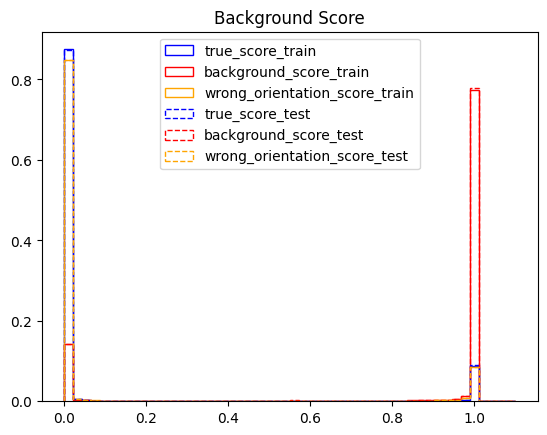

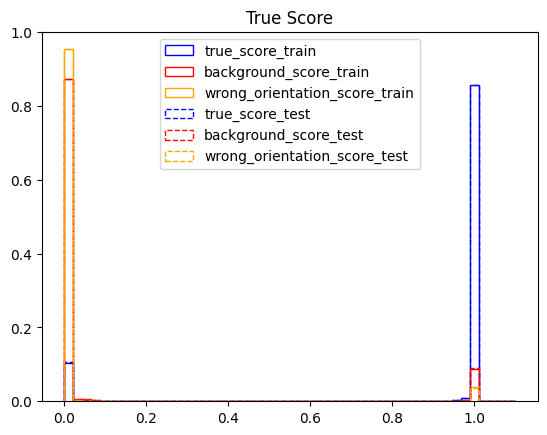

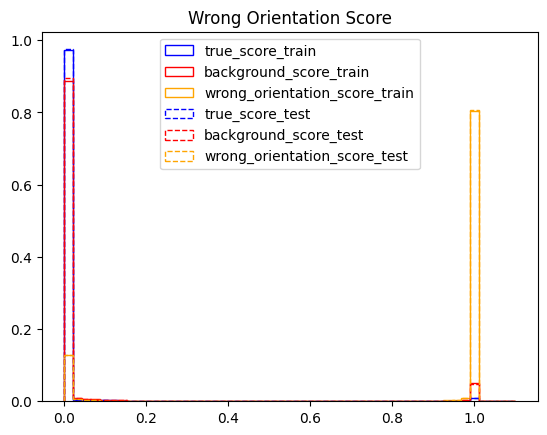

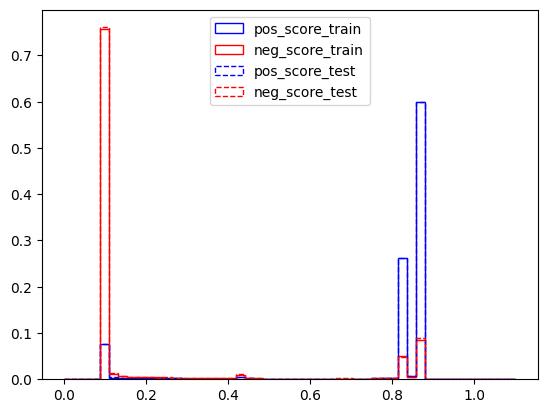

----------------------------------------
Epoch: 1
----------------------------------------
training_classification_loss: 0.62
----
optimal_threshold_train: 0.699999988079071
accuracy_train: 0.87%
positive_as_positive_fraction_train: 88.21%
positive_as_negative_fraction_train: 11.79%
negative_as_negative_fraction_train: 85.46%
negative_as_positive_fraction_train: 14.54%
----
testing_classification_loss: 0.62
----
optimal_threshold_test: 0.75
accuracy_test: 0.87%
positive_as_positive_fraction_test: 87.61%
positive_as_negative_fraction_test: 12.39%
negative_as_negative_fraction_test: 85.98%
negative_as_positive_fraction_test: 14.02%
----


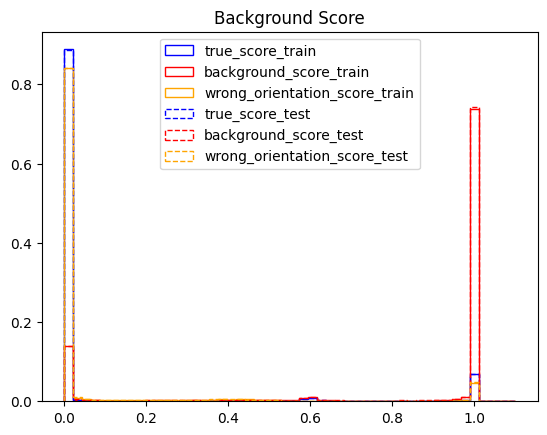

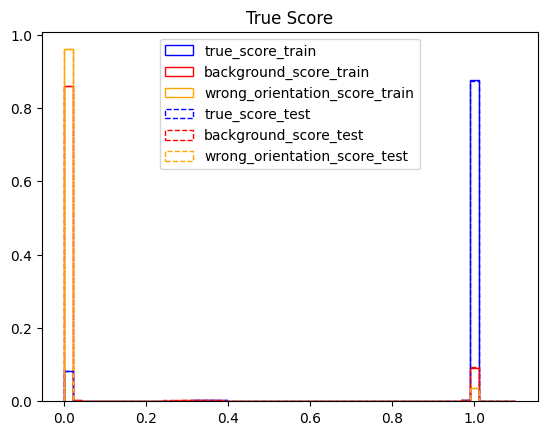

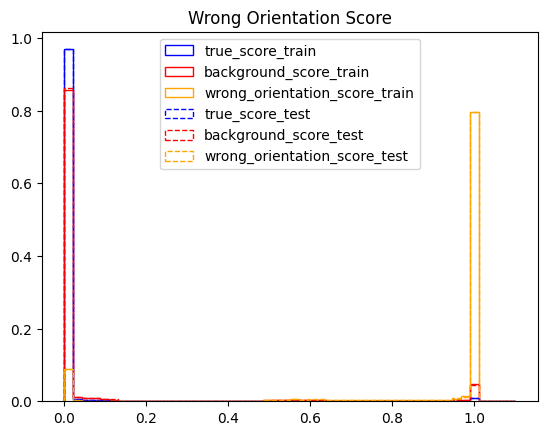

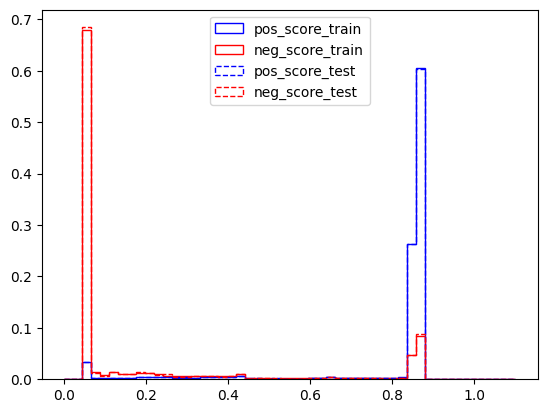

----------------------------------------
Epoch: 2
----------------------------------------
training_classification_loss: 0.6
----
optimal_threshold_train: 0.550000011920929
accuracy_train: 0.87%
positive_as_positive_fraction_train: 89.52%
positive_as_negative_fraction_train: 10.48%
negative_as_negative_fraction_train: 84.49%
negative_as_positive_fraction_train: 15.51%
----
testing_classification_loss: 0.61
----
optimal_threshold_test: 0.550000011920929
accuracy_test: 0.87%
positive_as_positive_fraction_test: 89.3%
positive_as_negative_fraction_test: 10.7%
negative_as_negative_fraction_test: 84.77%
negative_as_positive_fraction_test: 15.23%
----


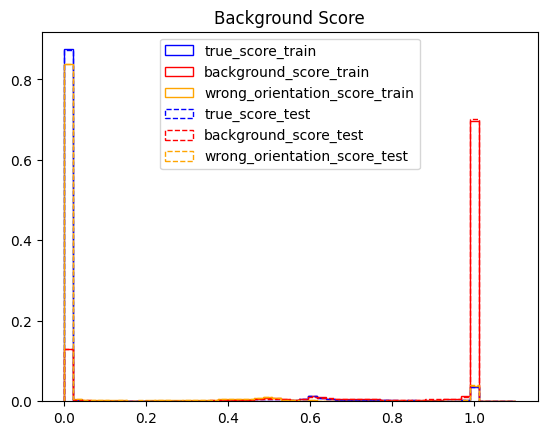

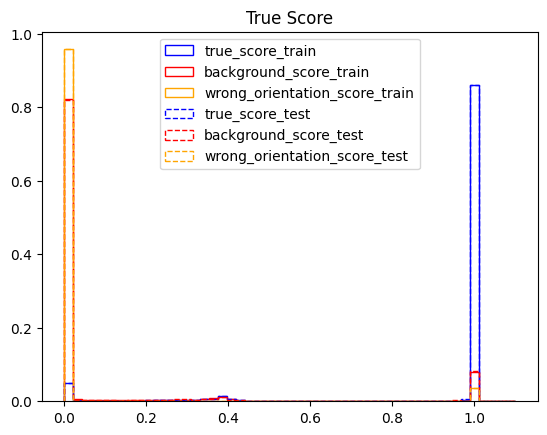

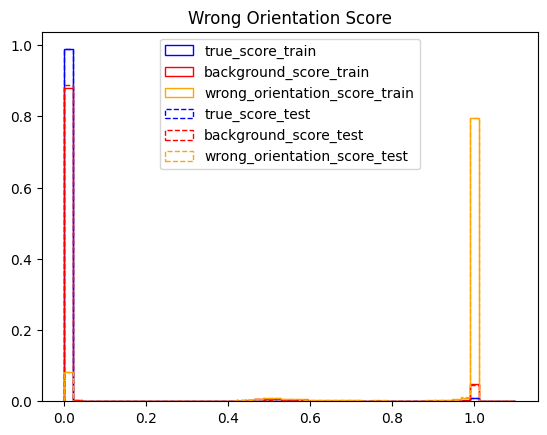

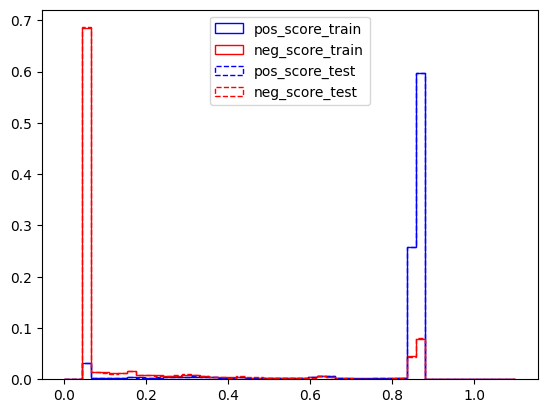

----------------------------------------
Epoch: 3
----------------------------------------
training_classification_loss: 0.6
----
optimal_threshold_train: 0.6499999761581421
accuracy_train: 0.87%
positive_as_positive_fraction_train: 89.38%
positive_as_negative_fraction_train: 10.62%
negative_as_negative_fraction_train: 84.75%
negative_as_positive_fraction_train: 15.25%
----
testing_classification_loss: 0.61
----
optimal_threshold_test: 0.6499999761581421
accuracy_test: 0.87%
positive_as_positive_fraction_test: 89.28%
positive_as_negative_fraction_test: 10.72%
negative_as_negative_fraction_test: 84.65%
negative_as_positive_fraction_test: 15.35%
----


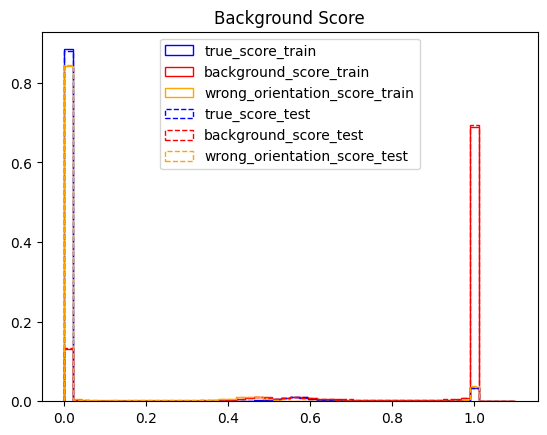

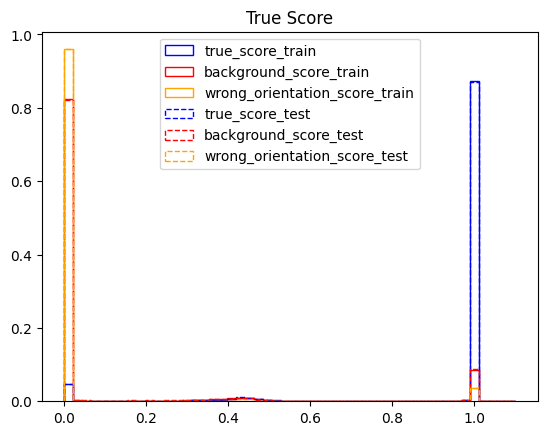

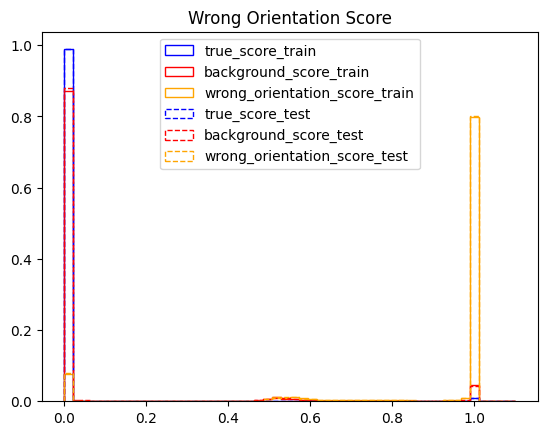

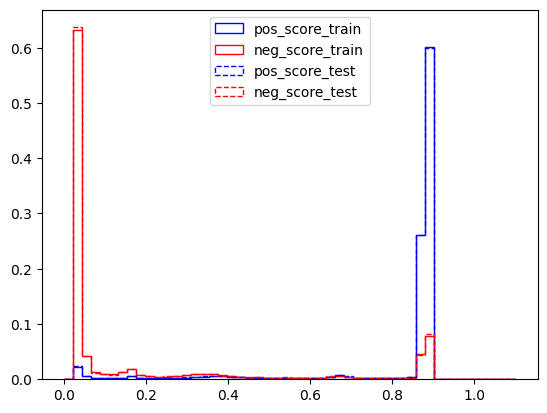

----------------------------------------
Epoch: 4
----------------------------------------
training_classification_loss: 0.59
----
optimal_threshold_train: 0.6499999761581421
accuracy_train: 0.87%
positive_as_positive_fraction_train: 88.35%
positive_as_negative_fraction_train: 11.65%
negative_as_negative_fraction_train: 85.7%
negative_as_positive_fraction_train: 14.3%
----
testing_classification_loss: 0.59
----
optimal_threshold_test: 0.6499999761581421
accuracy_test: 0.87%
positive_as_positive_fraction_test: 88.28%
positive_as_negative_fraction_test: 11.72%
negative_as_negative_fraction_test: 85.86%
negative_as_positive_fraction_test: 14.14%
----


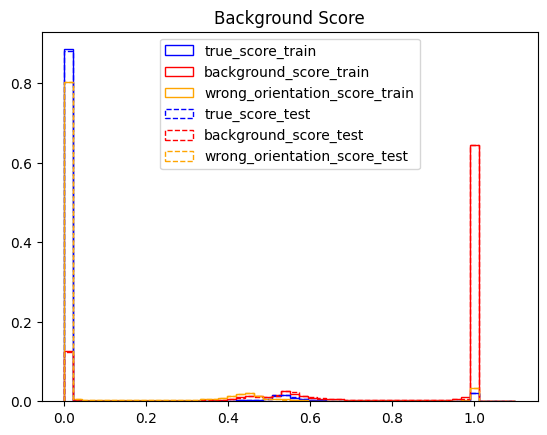

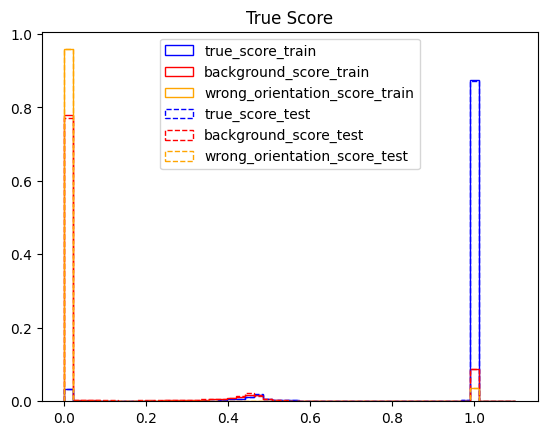

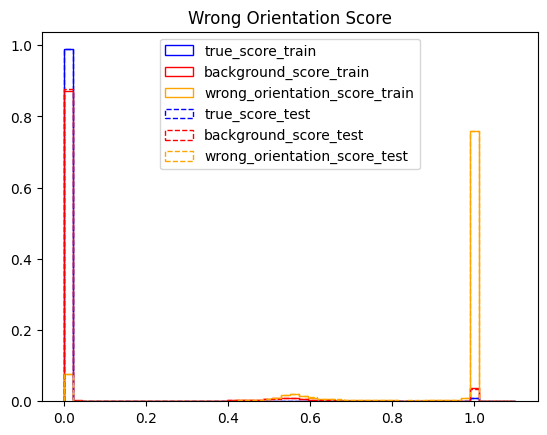

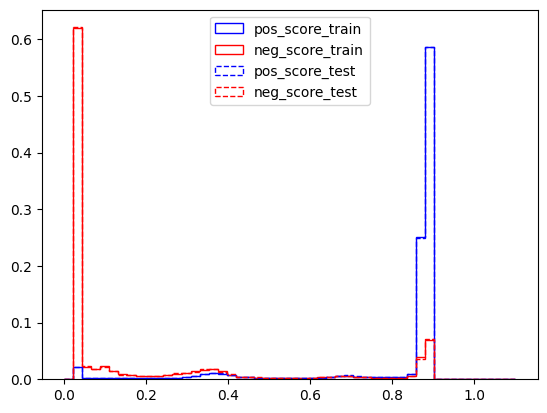

In [16]:
######################
# Training and testing
######################

# Optimiser
optimiser = torch.optim.Adam(itertools.chain(model_0.parameters(), classifier_model.parameters()), lr=LEARNING_RATE)
#loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights)

# Scheduler
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 'min', factor=0.1, patience=3, threshold=0.0001, threshold_mode='abs')

# Put here some metrics
training_epoch = []
training_loss_0 = []
training_loss_1 = []
training_classification_loss = []
training_accuracy = []
training_positive_as_positive_rate = []
training_positive_as_negative_rate = []
training_negative_as_negative_rate = []
training_negative_as_positive_rate = []

testing_epoch = []
testing_loss_0 = []
testing_loss_1 = []
testing_classification_loss = []
testing_accuracy = []
testing_positive_as_positive_rate = []
testing_positive_as_negative_rate = []
testing_negative_as_negative_rate = []
testing_negative_as_positive_rate = []

for epoch in range(N_EPOCHS):
    
    ######################
    # Training 
    ######################    
    model_0.train()
    classifier_model.train()
    
    # Iterate in batches over the training dataset.                        
    for features_0, features_1, target_0, target_1, target in loader_train:  
        
        # Skip incomplete batches
        if (target.shape[0] != BATCH_SIZE) :
            continue        
            
        # Get predictions
        pred_0 = model_0(features_0)
        pred_1 = model_0(features_1)
        classifier_pred = classifier_model(torch.concatenate((pred_0, pred_1), axis=1))
        
        # Get loss
        target_0 = target_0.to(torch.long)
        target_1 = target_1.to(torch.long)
        classifier_target = target.to(torch.long).reshape(-1,1)
        loss_0 = loss_function_branch(pred_0, target_0, classWeights_branch)        
        loss_1 = loss_function_branch(pred_1, target_1, classWeights_branch) 
        classifier_loss = loss_function_classifier(classifier_pred, classifier_target, classWeights_classifier)
        total_loss = loss_0 + loss_1 + classifier_loss
        
        # Update model parameters
        optimiser.zero_grad()
        total_loss.backward()
        optimiser.step()
        
    ######################
    # Validation metrics 
    ######################
    with torch.no_grad():
        
        # Begin testing mode
        model_0.eval()
        classifier_model.eval()
        
        # Initialise metrics        
        total_batches_train = 0        
        total_loss_0_train = 0
        true_scores_0_train = []
        background_scores_0_train = []
        wrong_orientation_scores_0_train = []
        total_loss_1_train = 0
        true_scores_1_train = []
        background_scores_1_train = []
        wrong_orientation_scores_1_train = []
        total_classification_loss_train = 0
        positive_scores_train = []
        negative_scores_train = []
        
        total_batches_test = 0        
        total_loss_0_test = 0
        true_scores_0_test = []
        background_scores_0_test = []
        wrong_orientation_scores_0_test = []
        total_loss_1_test = 0
        true_scores_1_test = []
        background_scores_1_test = []
        wrong_orientation_scores_1_test = []
        total_classification_loss_test = 0
        positive_scores_test = []
        negative_scores_test = []        
                
        # Iterate in batches over the training dataset.                        
        for features_0_train, features_1_train, target_0_train, target_1_train, target_train in loader_train:  

            # Skip incomplete batches
            if (target_train.shape[0] != BATCH_SIZE) :
                continue        

            # Get predictions
            pred_0_train = model_0(features_0_train)
            pred_1_train = model_0(features_1_train)
            classifier_pred_train = classifier_model(torch.concatenate((pred_0_train, pred_1_train), axis=1))

            # Get loss
            target_0_train = target_0_train.to(torch.long)
            target_1_train = target_1_train.to(torch.long)
            classifier_target_train = target_train.to(torch.long).reshape(-1,1)
            loss_0_train = loss_function_branch(pred_0_train, target_0_train, classWeights_branch)   
            loss_1_train = loss_function_branch(pred_1_train, target_1_train, classWeights_branch)
            classifier_loss_train = loss_function_classifier(classifier_pred_train, classifier_target_train, classWeights_classifier)
            total_loss_train = loss_0_train + loss_1_train + classifier_loss_train
            
            # Add to our metrics
            total_batches_train += 1            
            total_loss_0_train += loss_0_train.item()  
            true_scores_0_train.extend(np.array(pred_0_train.tolist())[torch.column_stack((target_0_train == 1, target_0_train == 1, target_0_train == 1)).numpy()].reshape(-1, 3))
            background_scores_0_train.extend(np.array(pred_0_train.tolist())[torch.column_stack((target_0_train == 0, target_0_train == 0, target_0_train == 0)).numpy()].reshape(-1, 3))
            wrong_orientation_scores_0_train.extend(np.array(pred_0_train.tolist())[torch.column_stack((target_0_train == 2, target_0_train == 2, target_0_train == 2)).numpy()].reshape(-1, 3))
            total_loss_1_train += loss_1_train.item()  
            true_scores_1_train.extend(np.array(pred_1_train.tolist())[torch.column_stack((target_1_train == 1, target_1_train == 1, target_1_train == 1)).numpy()].reshape(-1, 3))
            background_scores_1_train.extend(np.array(pred_1_train.tolist())[torch.column_stack((target_1_train == 0, target_1_train == 0, target_1_train == 0)).numpy()].reshape(-1, 3))
            wrong_orientation_scores_1_train.extend(np.array(pred_1_train.tolist())[torch.column_stack((target_1_train == 2, target_1_train == 2, target_1_train == 2)).numpy()].reshape(-1, 3))
            total_classification_loss_train += classifier_loss_train.item()
            positive_scores_train.extend(np.array(classifier_pred_train.tolist())[(classifier_target_train == 1).numpy()].reshape(-1))
            negative_scores_train.extend(np.array(classifier_pred_train.tolist())[(classifier_target_train == 0).numpy()].reshape(-1))
            
        training_epoch.append(epoch)            
            
        # Iterate in batches over the training dataset.                        
        for features_0_test, features_1_test, target_0_test, target_1_test, target_test in loader_test:  

            # Skip incomplete batches
            if (target_test.shape[0] != BATCH_SIZE) :
                continue        

            # Get predictions
            pred_0_test = model_0(features_0_test)
            pred_1_test = model_0(features_1_test)
            classifier_pred_test = classifier_model(torch.concatenate((pred_0_test, pred_1_test), axis=1))

            # Get loss
            target_0_test = target_0_test.to(torch.long)
            target_1_test = target_1_test.to(torch.long)
            classifier_target_test = target_test.to(torch.long).reshape(-1,1)
            loss_0_test = loss_function_branch(pred_0_test, target_0_test, classWeights_branch)   
            loss_1_test = loss_function_branch(pred_1_test, target_1_test, classWeights_branch)
            classifier_loss_test = loss_function_classifier(classifier_pred_test, classifier_target_test, classWeights_classifier)
            total_loss_test = loss_0_test + loss_1_test + classifier_loss_test
            
            # Add to our metrics
            total_batches_test += 1          
            total_loss_0_test += loss_0_test.item()             
            true_scores_0_test.extend(np.array(pred_0_test.tolist())[torch.column_stack((target_0_test == 1, target_0_test == 1, target_0_test == 1)).numpy()].reshape(-1, 3))
            background_scores_0_test.extend(np.array(pred_0_test.tolist())[torch.column_stack((target_0_test == 0, target_0_test == 0, target_0_test == 0)).numpy()].reshape(-1, 3))
            wrong_orientation_scores_0_test.extend(np.array(pred_0_test.tolist())[torch.column_stack((target_0_test == 2, target_0_test == 2, target_0_test == 2)).numpy()].reshape(-1, 3))
            total_loss_1_test += loss_1_test.item()             
            true_scores_1_test.extend(np.array(pred_1_test.tolist())[torch.column_stack((target_1_test == 1, target_1_test == 1, target_1_test == 1)).numpy()].reshape(-1, 3))
            background_scores_1_test.extend(np.array(pred_1_test.tolist())[torch.column_stack((target_1_test == 0, target_1_test == 0, target_1_test == 0)).numpy()].reshape(-1, 3))
            wrong_orientation_scores_1_test.extend(np.array(pred_1_test.tolist())[torch.column_stack((target_1_test == 2, target_1_test == 2, target_1_test == 2)).numpy()].reshape(-1, 3))
            total_classification_loss_test += classifier_loss_test.item()
            positive_scores_test.extend(np.array(classifier_pred_test.tolist())[(classifier_target_test == 1).numpy()].reshape(-1))
            negative_scores_test.extend(np.array(classifier_pred_test.tolist())[(classifier_target_test == 0).numpy()].reshape(-1))            
            
        testing_epoch.append(epoch)
    
    ##########################
    # Calc metrics for epoch 
    ##########################   
    # train
    optimal_threshold_train, maximum_accuracy_train = TrainingMetrics.calculate_accuracy(torch.tensor(positive_scores_train), torch.tensor(negative_scores_train)) 
    # test
    optimal_threshold_test, maximum_accuracy_test = TrainingMetrics.calculate_accuracy(torch.tensor(positive_scores_test), torch.tensor(negative_scores_test))

    # train
    positive_as_positive_train = np.count_nonzero(np.array(positive_scores_train) > optimal_threshold_train)
    positive_as_negative_train = np.count_nonzero(np.array(positive_scores_train) < optimal_threshold_train)
    negative_as_positive_train = np.count_nonzero(np.array(negative_scores_train) > optimal_threshold_train)
    negative_as_negative_train = np.count_nonzero(np.array(negative_scores_train) < optimal_threshold_train)
    # test
    positive_as_positive_test = np.count_nonzero(np.array(positive_scores_test) > optimal_threshold_test)
    positive_as_negative_test = np.count_nonzero(np.array(positive_scores_test) < optimal_threshold_test)
    negative_as_positive_test = np.count_nonzero(np.array(negative_scores_test) > optimal_threshold_test)
    negative_as_negative_test = np.count_nonzero(np.array(negative_scores_test) < optimal_threshold_test)
    
    # train
    positive_as_positive_fraction_train = float(positive_as_positive_train) / float(positive_as_positive_train + positive_as_negative_train)
    positive_as_negative_fraction_train = float(positive_as_negative_train) / float(positive_as_positive_train + positive_as_negative_train)
    negative_as_positive_fraction_train = float(negative_as_positive_train) / float(negative_as_positive_train + negative_as_negative_train)
    negative_as_negative_fraction_train = float(negative_as_negative_train) / float(negative_as_positive_train + negative_as_negative_train)
    # test
    positive_as_positive_fraction_test = float(positive_as_positive_test) / float(positive_as_positive_test + positive_as_negative_test)
    positive_as_negative_fraction_test = float(positive_as_negative_test) / float(positive_as_positive_test + positive_as_negative_test)
    negative_as_positive_fraction_test = float(negative_as_positive_test) / float(negative_as_positive_test + negative_as_negative_test)
    negative_as_negative_fraction_test = float(negative_as_negative_test) / float(negative_as_positive_test + negative_as_negative_test)
    
    # Add to our metrics
    training_loss_0.append(float(total_loss_0_train) / total_batches_train)
    training_loss_1.append(float(total_loss_1_train) / total_batches_train)
    training_classification_loss.append(float(total_classification_loss_train) / total_batches_train)
    training_accuracy.append(maximum_accuracy_train)
    training_positive_as_positive_rate.append(positive_as_positive_fraction_train)
    training_positive_as_negative_rate.append(positive_as_negative_fraction_train)
    training_negative_as_negative_rate.append(negative_as_negative_fraction_train)
    training_negative_as_positive_rate.append(negative_as_positive_fraction_train)
    
    testing_loss_0.append(float(total_loss_0_test) / total_batches_test)
    testing_loss_1.append(float(total_loss_1_test) / total_batches_test)
    testing_classification_loss.append(float(total_classification_loss_test) / total_batches_test)
    testing_positive_as_positive_rate.append(positive_as_positive_fraction_test)
    testing_positive_as_negative_rate.append(positive_as_negative_fraction_test)
    testing_negative_as_negative_rate.append(negative_as_negative_fraction_test)
    testing_negative_as_positive_rate.append(negative_as_positive_fraction_test)    
    
    # Do some prints
    print('----------------------------------------')
    print('Epoch:', epoch)
    print('----------------------------------------')
    print('training_classification_loss:', round(training_classification_loss[-1], 2))
    print('----')
    print('optimal_threshold_train:', optimal_threshold_train)
    print('accuracy_train:', str(round(maximum_accuracy_train.item(), 2)) +'%')
    print('positive_as_positive_fraction_train:', str(round(positive_as_positive_fraction_train * 100.0, 2)) + '%')
    print('positive_as_negative_fraction_train:', str(round(positive_as_negative_fraction_train * 100.0, 2)) + '%')
    print('negative_as_negative_fraction_train:', str(round(negative_as_negative_fraction_train * 100.0, 2)) + '%')
    print('negative_as_positive_fraction_train:', str(round(negative_as_positive_fraction_train * 100.0, 2)) + '%')
    print('----')
    print('testing_classification_loss:', round(testing_classification_loss[-1], 2))
    print('----')
    print('optimal_threshold_test:', optimal_threshold_test)
    print('accuracy_test:', str(round(maximum_accuracy_test.item(), 2)) +'%')
    print('positive_as_positive_fraction_test:', str(round(positive_as_positive_fraction_test * 100.0, 2)) + '%')
    print('positive_as_negative_fraction_test:', str(round(positive_as_negative_fraction_test * 100.0, 2)) + '%')
    print('negative_as_negative_fraction_test:', str(round(negative_as_negative_fraction_test * 100.0, 2)) + '%')
    print('negative_as_positive_fraction_test:', str(round(negative_as_positive_fraction_test * 100.0, 2)) + '%')
    print('----')
    TrainingMetrics.plot_scores_branch(background_scores_0_train, true_scores_0_train, wrong_orientation_scores_0_train, \
                                       background_scores_0_test, true_scores_0_test, wrong_orientation_scores_0_test, 0)
    TrainingMetrics.plot_scores_branch(background_scores_0_train, true_scores_0_train, wrong_orientation_scores_0_train, \
                                       background_scores_0_test, true_scores_0_test, wrong_orientation_scores_0_test, 1)
    TrainingMetrics.plot_scores_branch(background_scores_0_train, true_scores_0_train, wrong_orientation_scores_0_train, \
                                       background_scores_0_test, true_scores_0_test, wrong_orientation_scores_0_test, 2)   

# #     TrainingMetrics.plot_scores_branch(background_scores_1_train, true_scores_1_train, wrong_orientation_scores_1_train, \
# #                                        background_scores_1_test, true_scores_1_test, wrong_orientation_scores_1_test, 0)
# #     TrainingMetrics.plot_scores_branch(background_scores_1_train, true_scores_1_train, wrong_orientation_scores_1_train, \
# #                                        background_scores_1_test, true_scores_1_test, wrong_orientation_scores_1_test, 1)
# #     TrainingMetrics.plot_scores_branch(background_scores_1_train, true_scores_1_train, wrong_orientation_scores_1_train, \
# #                                        background_scores_1_test, true_scores_1_test, wrong_orientation_scores_1_test, 2)    
    TrainingMetrics.plot_scores_classifier(positive_scores_train, negative_scores_train, positive_scores_test, negative_scores_test)

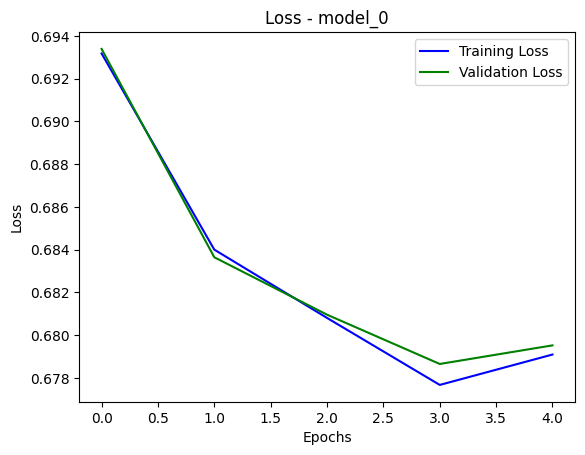

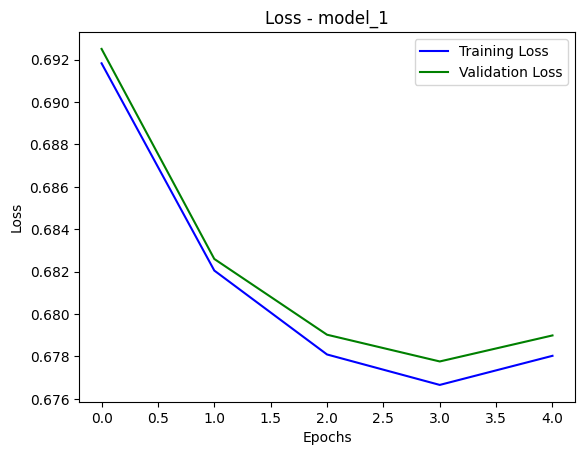

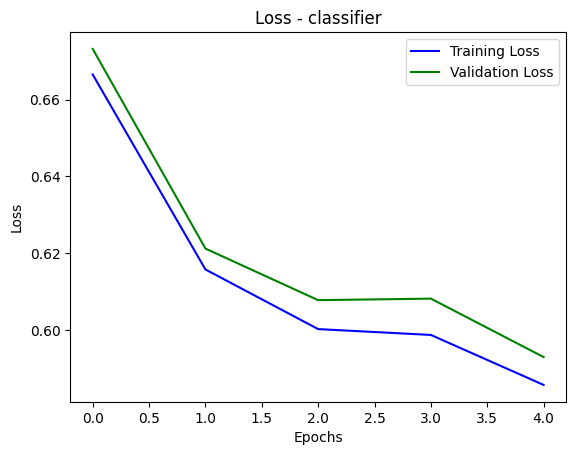

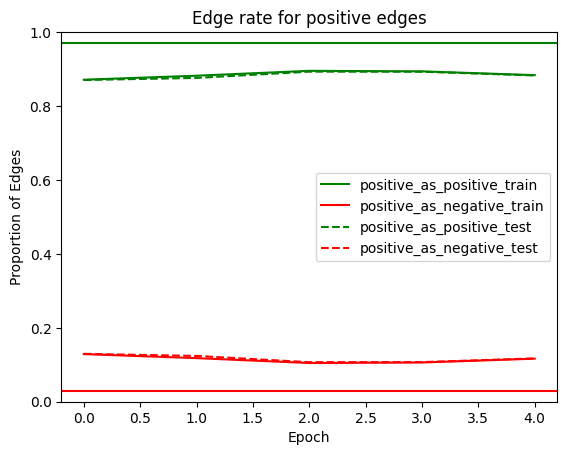

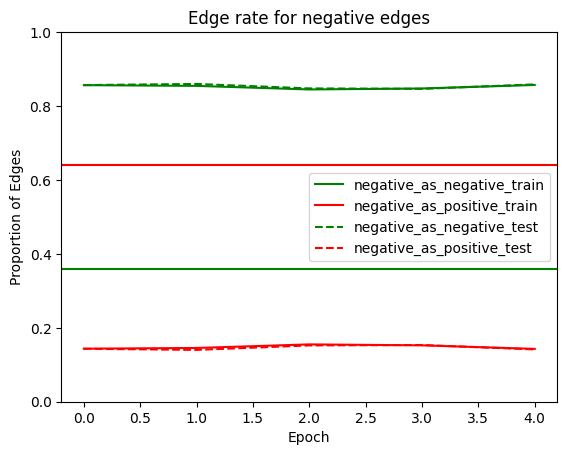

In [17]:
# Print metrics showing evolution   
TrainingMetrics.plot_loss_evolution(training_epoch, training_loss_0, testing_loss_0, 'Loss - model_0')
TrainingMetrics.plot_loss_evolution(training_epoch, training_loss_1, testing_loss_1, 'Loss - model_1')
TrainingMetrics.plot_loss_evolution(training_epoch, training_classification_loss, testing_classification_loss, 'Loss - classifier')
TrainingMetrics.plot_edge_rate(training_epoch, training_positive_as_positive_rate, training_positive_as_negative_rate, testing_positive_as_positive_rate, testing_positive_as_negative_rate, True)
TrainingMetrics.plot_edge_rate(testing_epoch, training_negative_as_negative_rate, training_negative_as_positive_rate, testing_negative_as_negative_rate, testing_negative_as_positive_rate, False)

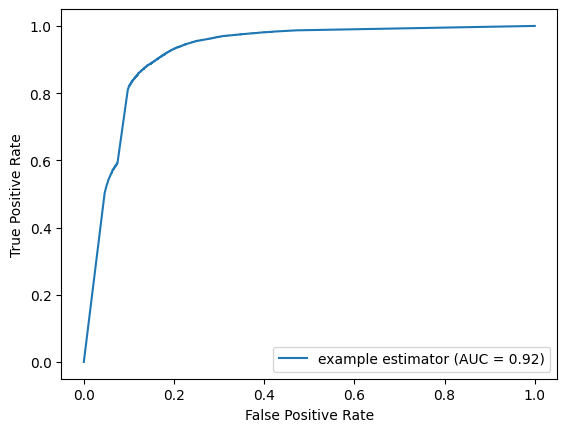

[[ 6331  1180]
 [ 5013 43200]]
[[ 6386  1125]
 [ 5357 42856]]


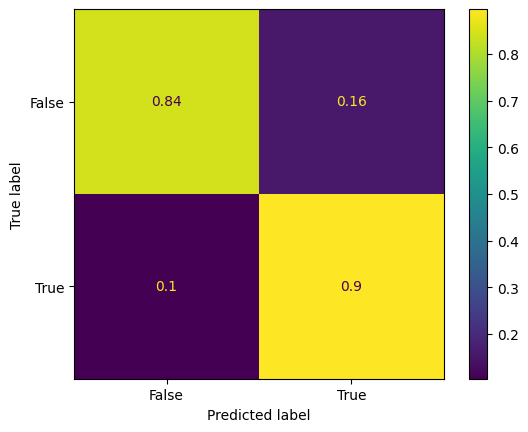

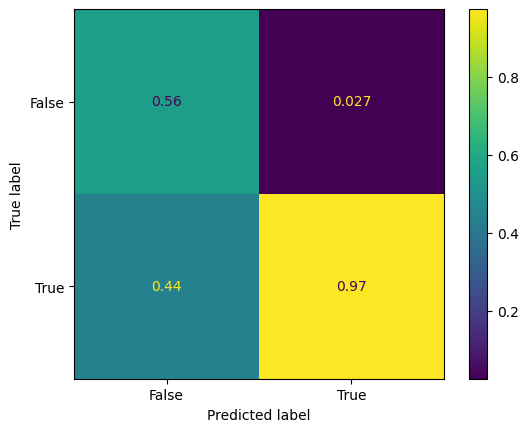

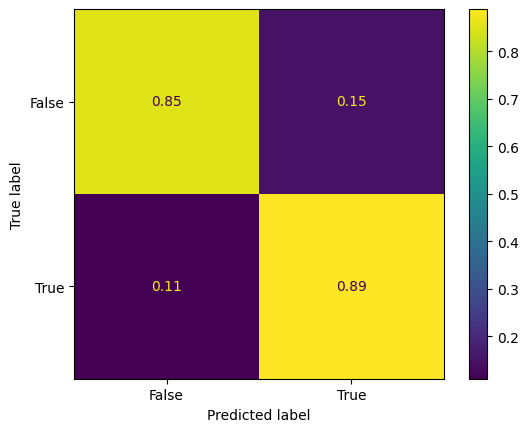

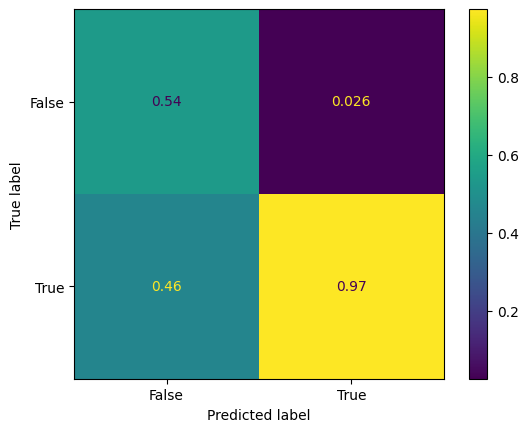

In [18]:
######################
# Confusion matrices!
######################
with torch.no_grad():

    # Begin testing mode
    model_0.eval()
    classifier_model.eval()
    # Get predictions
    pred_0_test = model_0(torch.tensor(input_0_test_temp, dtype=torch.float))
    pred_1_test = model_0(torch.tensor(input_1_test_temp, dtype=torch.float))
    classifier_pred_test = classifier_model(torch.concatenate((pred_0_test, pred_1_test), axis=1)).reshape(-1)

    neg_scores_final_test = np.array(classifier_pred_test.tolist())[isTruePrimaryLink_test == 0].reshape(-1)
    pos_scores_final_test = np.array(classifier_pred_test.tolist())[isTruePrimaryLink_test == 1].reshape(-1)
    
    TrainingMetrics.plot_roc_curve(torch.tensor(pos_scores_final_test), torch.tensor(neg_scores_final_test))
    TrainingMetrics.draw_confusion_with_threshold(classifier_pred_test, isTruePrimaryLink_test, 0.5)
    TrainingMetrics.draw_confusion_with_threshold(classifier_pred_test, isTruePrimaryLink_test, 0.60)

In [19]:
######################
# Save the model
###################### 
sm_0 = torch.jit.script(model_0)
sm_0.save("/Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_track_branch_model_torch")

sm = torch.jit.script(classifier_model)
sm.save("/Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_track_classifier_model_torch")

